In [76]:
import os
import tensorflow as tf
import numpy as np
import random

os.environ['PYTHONHASHSEED'] = str(123) # Python general
np.random.seed(123)
random.seed(123)
tf.random.set_seed(123)
os.environ['TF_DETERMINISTIC_OPS'] = '1'
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

tf.config.threading.set_inter_op_parallelism_threads(1)
tf.config.threading.set_intra_op_parallelism_threads(1)

import json
import math
from typing import Tuple, List
%matplotlib inline
from matplotlib import pyplot as plt

import pandas as pd

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

from pickle import dump
from deap import base
from deap import creator
from deap import tools

from configs import LSTMConfig
import elitism

In [14]:
# PART 1. Data processing.

In [15]:
class UnivariateMultiTransformer:
    """Represents data preparation for the LSTM model.
    
    Attributes:
        sequence (pd.DadaFrame): uploaded resampled 
            time series.
        path (str): path to .csv with the data.
        scaler (sklearn.preprocessing object): scaler used to scale
            sequence.
        train (pd.DataFrame): training dataset.
        test (pd.DataFrame): test dataset.
        train_scaled (pd.DataFrame): scaled training dataset.
        test_scaled (pd.DataFrame): scaled test dataset.
    
    Methods:
        upload(path: str, sample): uploads file from path.
        set_month_range(months): provides sub-frame based on months.
        train_test_split(train_percent): 
            splits sequence to train and test (validation) sets.
        scale(scaling): scales sequence to [0, 1] range ('norm').
        transform(data_type, n_in, n_out, dropnan):
            converts train and test sequences to classification problem.
        model_input_reshape(x1, x2): reshapes 2D arrays to 3D arrays.
        save_scaler(path): saves scaler to the provided file path. 

    """
    
    def __init__(self, path: str) -> None:
        """Initializes UnivariateMultiTransformer.
        
        Args:
            path (str): path to .csv with the data.

        Returns:
            None.
        """
        
        self.sequence = self.upload(path)
        self.scaler = None
        self.train = None
        self.test = None
        self.train_scaled = None
        self.test_scaled = None
    
    @staticmethod
    def upload(path: str, sample='60min') -> pd.DataFrame:
        """Uploads file from path. Univariate time series
        should be provided with two columns: date and values.
        Sets column names to 'time' and 'value'.
        
        Args:
            path (str): path to .csv with the data.
            sample (str): represents sampling period.
            
        Returns:
            data (pd.DataFrame): read resampled data frame.
        """

        data = pd.read_csv(path, parse_dates=True, 
                           index_col=0, 
                           names=['time','value'])

        # resample xx minutes data to 1 hour
        data = data.resample(sample).mean()
        # just to visualize what you got :) 
        plt.plot(data)

        return data

    
    def set_month_range(self, months=(6, 7, 8)) -> None:
        """Provides sub-frame based on months.
        
        Args:
            months (List[int]): path to .csv with the data.
        
        Returns:
            None.
        """
        
        self.sequence = self.sequence[
            self.sequence.index.month.isin(months)]
        
    def train_test_split(self, train_percent=0.8) -> None:
        """Splits sequence to train and test (validation) sets.
        
        Args:
            train_percent (float): percent of data goes to the 
                training set.
        
        Returns:
            None.
        """
        
        training_length = math.ceil(len(self.sequence)*
                                    train_percent)
        self.train = self.sequence[0:training_length]
        self.test = self.sequence[training_length:]
    
    def scale(self, scaling='norm') -> None:
        """Scales sequence to [0, 1] range ('norm')
        or zero mean and 1 standard deviation. 
        Depends on sklearn.preprocessing module.
        
        Args:
            scaling (str): scaling method.
            'norm' - normalization
            'standard': standardization. 
        
        Returns:
            None.
        """
        if scaling == 'norm':
            self.scaler = MinMaxScaler(feature_range=(0, 1))
        elif scaling == 'standard':
            self.scaler = StandardScaler()
        
        if self.train is not None and self.test is not None:
            self.scaler.fit(self.train)
            # remember to fit scaler on the training data firstly! 
            self.train_scaled = pd.DataFrame(
                data=self.scaler.transform(self.train),
                index=self.train.index, columns=['value'])
            self.test_scaled = pd.DataFrame(
                data=self.scaler.transform(self.test),
                index=self.test.index, columns=['value'])
        else:
            raise ValueError('train_test_split must be invoked firstly')
   
    def transform(self, data_type='train', n_in=24, n_out=24, 
                      dropnan=True) -> Tuple[np.array, np.array]:
        """Converts train and test sequences to classification problem.
        It is the legacy method. Applied only to the scaled data.
        
        Args:
            data_type (str): specifies which data to transform.
                'train' or 'test' are available options.
            n_in (int): lag,  number of point used to 
                predict next sub-sequence.  
            n_out (int): number of point to be predicted.
            dropnan (bool): defines droping of nan contained 
                sub-sequences. 
        
        Returns:
            x (numpy.array): training data
            y (numpy.array): test data.
        """
        
        if data_type == 'train':
            data = self.train_scaled
        elif data_type == 'test':
            data = self.test_scaled
        
        variables = data.shape[1]
        columns = []
        column_names = []
        
        # foregoing sequence (x-n, ..., x-1)
        for i in range(n_in, 0, -1):
            columns.append(data.shift(i))
            column_names += [('value%d(x-%d)' % (j+1, i)) 
                      for j in range(variables)]
            
        # forecast sequence (t, t+1, ... t+n)
        for i in range(0, n_out):
            columns.append(data.shift(-i))
            if i == 0:
                column_names += [('value%d(x)' % (j+1)) 
                          for j in range(variables)]
            else:
                column_names += [('value%d(x+%d)' % (j+1, i)) 
                          for j in range(variables)]

        # concat everything into one data frame
        df = pd.concat(columns, axis=1)
        df.columns = column_names
        
        # get rid of nan's
        if dropnan:
            df.dropna(inplace=True)
        
        # convert data frames into the numpy arrays
        x = df.iloc[:, :n_in].to_numpy()
        y = df.iloc[:,:-n_out].to_numpy()
        print(f'X shape: {x.shape}')
        print(f'y shape: {y.shape}')
        
        return x, y
    
    def model_input_reshape(self, x1: np.array, 
                            x2: np.array) -> Tuple[np.array, np.array]:
        """Reshapes 2D arrays to 3D arrays. 
        Remember, LSTM wants input in [sample, step, feature] form.
        
        Args:
            x1 (numpy.array): train numpy array.
            x2 (numpy.array): test (validation) numpy array.
       
        Returns:
            x1_new (numpy.array): train reshaped 3D array.
            x2_new (numpy.array): test reshaped 3D array.
        """
       
        x1_new = np.reshape(x1, (x1.shape[0], x1.shape[1], 1))
        x2_new = np.reshape(x2, (x2.shape[0], x2.shape[1], 1))
        
        print(f'x1 new shape: {x1_new.shape}')
        print(f'x2 new shape: {x2_new.shape}')
        
        return x1_new, x2_new 
        
    
    def save_scaler(self, path='scaler.pkl') -> None:
        """Saves scaler to the provided file path.
        
        Args:
            path (str): path to scaler to be saved.
        
        Returns:
            None.
        """
        
        dump(self.scaler, open(path, 'wb'))
        print(f'Scaler has been saved to {path}')

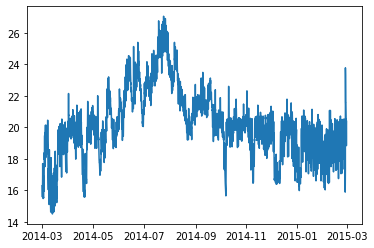

In [16]:
umt = UnivariateMultiTransformer(path='Air temperature.csv')
umt.set_month_range()

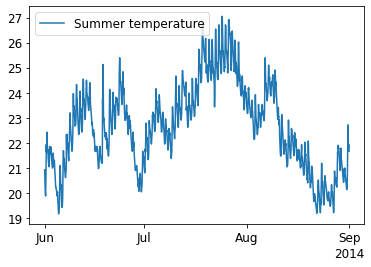

In [17]:
import matplotlib.dates as mdates
plt.rcParams.update({'font.size': 12})
ax = plt.axes()
locator = mdates.AutoDateLocator(minticks=3, maxticks=7)
formatter = mdates.ConciseDateFormatter(locator)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)

plt.plot(umt.sequence, label='Summer temperature')
plt.legend(loc='upper left')
plt.savefig('temperature.png', format='png', dpi=300)

In [18]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(umt.sequence.values)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.374843
p-value: 0.148963
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567


In [19]:
umt.train_test_split(train_percent=.8)
umt.scale()
umt.save_scaler()

Scaler has been saved to scaler.pkl


In [20]:
# convert data to classification problem

x_train_sc, y_train_sc = umt.transform(data_type='train', n_in=24, n_out=24)
x_test_sc, y_test_sc = umt.transform(data_type='test', n_in=24, n_out=24)

X shape: (1720, 24)
y shape: (1720, 24)
X shape: (394, 24)
y shape: (394, 24)


In [21]:
# reshape arrays for the model input

x_train_sc, x_test_sc = umt.model_input_reshape(x1=x_train_sc, x2=x_test_sc)

x1 new shape: (1720, 24, 1)
x2 new shape: (394, 24, 1)


In [22]:
steps = x_train_sc.shape[1]
features = x_train_sc.shape[2]
outputs = y_train_sc.shape[1]

In [23]:
y_train_sc.shape

(1720, 24)

In [24]:
# Part 2. GA for hyperparameters tuning. Using deap lib.

In [77]:
best_cached_model = []
best_mse = float("inf")
model_trained_predictions = []

In [78]:
# Model class representation

class GenOneLayerSequenceModel:
    """Class represents stateless GRU and LSTS models
    for GA hyperparameters selection.
    
    Attributes:
        train_set (list[numpy.array, numpy.array]): train set 
            [x_train, y_train].
        test_set (list[numpy.array, numpy.array]): test set
            [x_test, y_test]
        input_shape (dict): defines input 
            shape for the model.
                input_shape = {'timesteps': ...,
                'features': ...}.
        model (keras.model): sequence compiled model.
        parameters (dict): converted from GA individuals
            hyperparameters.
 
    Methods:
            
    """
    
    LEARNING_RATES = [0.01, 0.05, 0.1]
    OPTIMIZERS = ['Adam', 'Nadam', 'SGD']
    BATCHES = [16, 32, 64, 128]
    DROPOUTS = [0.0, 0.2, 0.4]
    
    
    def __init__(self, train_set: tuple, test_set: tuple, 
                 input_shape):
        """Initialize GenOneLayerSequenceModel.
        
        Args:
            train_set (tuple[numpy.array, numpy.array]): train set
                [x_train, y_train].
            test_set (tuple[numpy.array, numpy.array]): test set
                [x_test, y_test]
            input_shape (dict): defines input 
                shape for the model.
                input_shape = {'timesteps': ...,
                'features': ...}
        Returns:
            None.
        """
        self.train_set = train_set
        self.test_set = test_set
        self.input_shape = input_shape
        self.model = None
        self.parameters = None
    
    def set_hyper(self, args) -> dict:
        """Converts and sets provided in kwargs encoded hyperparameters
        from GA algorithm. 
        
        converted_parameters (dict): dictionary of decoded args,
                order is equivalent to args order.
                
        Args:
            args[0] (float): number of neurons.
            args[1] (float): encoded activation function.
            args[2] (float): encoded learning rate.
            args[3] (float): encoded optimizer.
            args[4] (float): encoded batch size.
            args[5] (float): encoded dropout.
        
        Returns:
            converted_parameters (dict): converted real hyperparameters.
        """
        
        parameters = args
        converted_parameters = dict()
        converted_parameters['n_neurons'] = round(parameters[0])
        converted_parameters['learning_rate'] = self.LEARNING_RATES[math.floor(parameters[1])]
        converted_parameters['optimizer'] = self.OPTIMIZERS[math.floor(parameters[2])]
        converted_parameters['batch_size'] = self.BATCHES[math.floor(parameters[3])]
        converted_parameters['dropout'] = self.DROPOUTS[math.floor(parameters[4])]
        
        self.parameters = converted_parameters
        
        return converted_parameters
    
    def create_model(self, input_shape, output_dense, parameters, 
                     cell_type):
        """Model configuration and compilation.
        """
        # convert GA individuals to real parameters
        _ = self.set_hyper(parameters)
        
        inputs = tf.keras.Input(shape=(self.input_shape["timesteps"],
                              self.input_shape["features"]))
        
        if cell_type == 'LSTM':
            x = tf.keras.layers.LSTM(self.parameters['n_neurons'],
                     activation='tanh',
                     input_shape=(self.input_shape["timesteps"],
                                  self.input_shape["features"]),
                    dropout=self.parameters["dropout"])(inputs)
        else:
            x = tf.keras.layers.GRU(self.parameters['n_neurons'],
                    activation='tanh',
                    input_shape=(self.input_shape["timesteps"],
                                 self.input_shape["features"]),
                   dropout=self.parameters["dropout"])(inputs)
            
        outputs = tf.keras.layers.Dense(output_dense)(x)
        model = tf.keras.Model(inputs=inputs, outputs=outputs)
        if self.parameters['optimizer'] == 'Adam':
            opt = tf.keras.optimizers.Adam(learning_rate=self.parameters['learning_rate'])
        elif self.parameters['optimizer'] == 'Nadam':
            opt = tf.keras.optimizers.Nadam(learning_rate=self.parameters['learning_rate'])
        elif self.parameters['optimizer'] == 'SGD':
            opt = tf.keras.optimizers.SGD(learning_rate=self.parameters['learning_rate'])
        
        model.compile(loss='mse', optimizer=opt)
        self.model = model
    
    def accucary_fitness_function(self):
        """"""
        global best_mse
        global best_cached_model
        history = self.model.fit(self.train_set[0], self.train_set[1], epochs=30, 
                                 batch_size=self.parameters["batch_size"],
                                 validation_data=(self.test_set[0], 
                                                  self.test_set[1]),
                                 verbose=0, 
                                 shuffle=False)
        # Get the predicted values
        prediction = self.model.predict(self.test_set[0])
        # print(f'Test set item x: {self.test_set[0][0]}')
        # print(f'Test set item y: {self.test_set[1][0]}')
        print(f'MSE inside fitness function: {self.parameters}')
        model_trained_predictions.append(prediction)
        
        mse = np.mean(np.square(prediction - self.test_set[1]))
        
        # let's save the best model by far
        if mse < best_mse:
            best_mse = mse
            best_cached_model = [self.model, history]
            print(f"Best model by far has mse={best_mse}")
 
        return mse
    
    def get_results(self, parameters):
        real_parameters = self.set_hyper(parameters)
        return "'n_neurons'={}\n " \
               "'learning_rate'='{}'\n " \
               "'optimizer'={}\n " \
               "'batch_size'='{}'"\
               "'dropout'='{}'"\
            .format(real_parameters['n_neurons'], 
                    real_parameters['learning_rate'], real_parameters['optimizer'], 
                    real_parameters['batch_size'], real_parameters['dropout'])        

In [79]:
# boundaries for all parameters:
# n_neurons: [50...200]
# learning_rate: [0.01, 0.05, 0.1] -> 0, 1, 2
# optimizer: ['Adam', 'Nadam', 'SGD'] -> 0, 1, 2
# batch_size: [16, 32, 64, 128] -> 0, 1, 2, 3
# dropout: [0.0, 0.2, 0.4] -> 0, 1, 2.

BOUNDS_LOW =  [100,     0,    0,      0,      0,   ]
BOUNDS_HIGH = [300,  2.999,  2.999, 3.999, 2.999, ]

NUM_OF_PARAMS = len(BOUNDS_HIGH)

# Genetic Algorithm constants:
POPULATION_SIZE = 20
P_CROSSOVER = 0.9  # probability for crossover
P_MUTATION = 0.3   # probability for mutating an individual
MAX_GENERATIONS = 10
HALL_OF_FAME_SIZE = 3
CROWDING_FACTOR = 10.0  # crowding factor for crossover and mutation

In [80]:
toolbox = base.Toolbox()

# define a single objective, minimizing fitness strategy:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))

# create the Individual class based on list:
creator.create("Individual", list, fitness=creator.FitnessMin)

# define the layer size attributes individually:
for i in range(NUM_OF_PARAMS):
    # "attribute_0", "attribute_1", ...
    toolbox.register("attribute_" + str(i),
                     random.uniform,
                     BOUNDS_LOW[i],
                     BOUNDS_HIGH[i])

# create a tuple containing an attribute generator for each param searched:
attributes = ()
for i in range(NUM_OF_PARAMS):
    attributes = attributes + (toolbox.__getattribute__("attribute_" + str(i)),)

# create the individual operator to fill up an Individual instance:
toolbox.register("individualCreator",
                 tools.initCycle,
                 creator.Individual,
                 attributes,
                 n=1)
# create the population operator to generate a list of individuals:
toolbox.register("populationCreator",
                 tools.initRepeat,
                 list,
                 toolbox.individualCreator)


# fitness calculation
def accuracy(individual):
    
    gen_model = GenOneLayerSequenceModel((x_train_sc, y_train_sc), 
                                         (x_test_sc, y_test_sc), 
                                         input_shape={'timesteps': 24, 'features': 1})
    
    gen_model.create_model(input_shape={'timesteps': 24, 
                                        'features': 1}, 
                           output_dense=24, parameters=individual, 
                           cell_type='GRU')
    result = gen_model.accucary_fitness_function()
    print(f"MSE: {result}")
    
    return result,


toolbox.register("evaluate", accuracy)

# genetic operators:
toolbox.register("select", tools.selTournament, tournsize=2)
toolbox.register("mate",
                 tools.cxSimulatedBinaryBounded,
                 low=BOUNDS_LOW,
                 up=BOUNDS_HIGH,
                 eta=CROWDING_FACTOR)

toolbox.register("mutate",
                 tools.mutPolynomialBounded,
                 low=BOUNDS_LOW,
                 up=BOUNDS_HIGH,
                 eta=CROWDING_FACTOR,
                 indpb=1.0/NUM_OF_PARAMS)

population = toolbox.populationCreator(n=POPULATION_SIZE)

# prepare the statistics object:
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("min", np.min)
stats.register("avg", np.mean)

# define the hall-of-fame object:
hof = tools.HallOfFame(HALL_OF_FAME_SIZE)

In [81]:
population, logbook = elitism.eaSimpleWithElitism(population,
                                                      toolbox,
                                                      cxpb=P_CROSSOVER,
                                                      mutpb=P_MUTATION,
                                                      ngen=MAX_GENERATIONS,
                                                      stats=stats,
                                                      halloffame=hof,
                                                      verbose=True)

MSE inside fitness function: {'n_neurons': 110, 'learning_rate': 0.01, 'optimizer': 'Nadam', 'batch_size': 16, 'dropout': 0.4}
Best model by far has mse=0.006173190497404964
MSE: 0.006173190497404964
MSE inside fitness function: {'n_neurons': 108, 'learning_rate': 0.05, 'optimizer': 'Adam', 'batch_size': 128, 'dropout': 0.0}
MSE: 0.1368355760372338
MSE inside fitness function: {'n_neurons': 167, 'learning_rate': 0.05, 'optimizer': 'Adam', 'batch_size': 16, 'dropout': 0.2}
MSE: 0.08040324359612024
MSE inside fitness function: {'n_neurons': 118, 'learning_rate': 0.05, 'optimizer': 'Adam', 'batch_size': 32, 'dropout': 0.2}
MSE: 0.09039574564838937
MSE inside fitness function: {'n_neurons': 281, 'learning_rate': 0.01, 'optimizer': 'Adam', 'batch_size': 128, 'dropout': 0.0}
Best model by far has mse=0.004667385152434593
MSE: 0.004667385152434593
MSE inside fitness function: {'n_neurons': 282, 'learning_rate': 0.05, 'optimizer': 'Adam', 'batch_size': 128, 'dropout': 0.4}
MSE: 0.2810958432657

In [84]:
model_trained_predictions[111]

array([[0.4487308 , 0.4469921 , 0.4397293 , ..., 0.3945604 , 0.42158228,
        0.43902397],
       [0.46206388, 0.45315906, 0.43716437, ..., 0.4161932 , 0.4302944 ,
        0.43500322],
       [0.43177894, 0.42345023, 0.4091834 , ..., 0.4288985 , 0.431391  ,
        0.42737162],
       ...,
       [0.23482135, 0.23174518, 0.21957894, ..., 0.1996836 , 0.19496588,
        0.19924505],
       [0.22394207, 0.22122559, 0.21102983, ..., 0.19341393, 0.19054012,
        0.19591714],
       [0.2147975 , 0.21173632, 0.20305918, ..., 0.18661425, 0.18319495,
        0.18796757]], dtype=float32)

In [82]:
best_cached_model

In [83]:
preds_to_check = best_cached_model[0].predict(x_test_sc)
preds_to_check

array([[0.4487308 , 0.4469921 , 0.4397293 , ..., 0.3945604 , 0.42158228,
        0.43902397],
       [0.46206388, 0.45315906, 0.43716437, ..., 0.4161932 , 0.4302944 ,
        0.43500322],
       [0.43177894, 0.42345023, 0.4091834 , ..., 0.4288985 , 0.431391  ,
        0.42737162],
       ...,
       [0.23482135, 0.23174518, 0.21957894, ..., 0.1996836 , 0.19496588,
        0.19924505],
       [0.22394207, 0.22122559, 0.21102983, ..., 0.19341393, 0.19054012,
        0.19591714],
       [0.2147975 , 0.21173632, 0.20305918, ..., 0.18661425, 0.18319495,
        0.18796757]], dtype=float32)

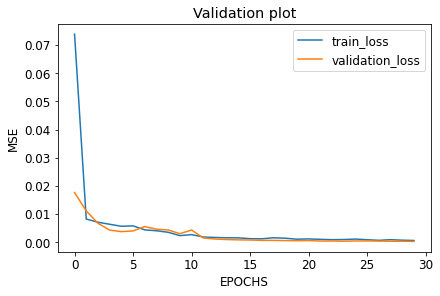

In [85]:
best_cached_model[1]
plt.rcParams.update({'font.size': 12})
fig, ax = plt.subplots(constrained_layout=True)
ax.plot(best_cached_model[1].history['loss'])
ax.plot(best_cached_model[1].history['val_loss'])
ax.set_xlabel('EPOCHS')
ax.set_ylabel('MSE')
ax.set_title('Validation plot')

plt.legend(['train_loss', 'validation_loss'], loc='upper right')
plt.savefig('lstm.png', format='png', dpi=300)

In [86]:
best_cached_model[0].save('gru.h5')

In [87]:
# saving test numpy array
with open('x_test.npy', 'wb') as f:
    np.save(f, x_test_sc)

In [ ]:
with open('prediction.npy', 'wb') as f:
    np.save(f, predictions)

In [ ]:
# PART 3. Best model 

In [39]:
best_hyperparameters = hof.items[0]
best_hyperparameters

[169.4944108392966,
 0.2638675752975591,
 1.9264140946325754,
 1.321617381765241,
 0.8126450908463536]

In [40]:
# lowest rmse value
hof.items[0].fitness.values[0]

0.0003025055094800904

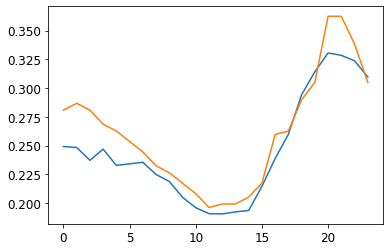

In [69]:
plt.plot(preds_to_check[100])
plt.plot(y_test_sc[100])

In [70]:
# "reproducing" trained model
# put here hyper-parameters from optimization
inputs_ = tf.keras.Input(shape=(24,1))

x_ = tf.keras.layers.LSTM(150, activation='tanh', input_shape=(24,1), dropout=0.0)(inputs_)
outputs_ = tf.keras.layers.Dense(24)(x_)
model_ = tf.keras.Model(inputs=inputs_, outputs=outputs_)
opt_ = tf.keras.optimizers.Nadam(learning_rate=0.01)
model_.compile(loss='mse', optimizer=opt_)

h = model_.fit(x_train_sc, y_train_sc, epochs=30, 
              batch_size=32, verbose=1,
              validation_data=(x_test_sc, y_test_sc), shuffle=False)

Epoch 1/30
54/54 [==============================] - 1s 12ms/step - loss: 0.0815 - val_loss: 0.0702
Epoch 2/30
54/54 [==============================] - 0s 7ms/step - loss: 0.0163 - val_loss: 0.0688
Epoch 3/30
54/54 [==============================] - 0s 7ms/step - loss: 0.0150 - val_loss: 0.0582
Epoch 4/30
54/54 [==============================] - 0s 7ms/step - loss: 0.0128 - val_loss: 0.0336
Epoch 5/30
54/54 [==============================] - 0s 7ms/step - loss: 0.0101 - val_loss: 0.0127
Epoch 6/30
54/54 [==============================] - 0s 7ms/step - loss: 0.0083 - val_loss: 0.0063
Epoch 7/30
54/54 [==============================] - 0s 7ms/step - loss: 0.0071 - val_loss: 0.0048
Epoch 8/30
54/54 [==============================] - 0s 6ms/step - loss: 0.0074 - val_loss: 0.0062
Epoch 9/30
54/54 [==============================] - 0s 7ms/step - loss: 0.0067 - val_loss: 0.0065
Epoch 10/30
54/54 [==============================] - 0s 7ms/step - loss: 0.0061 - val_loss: 0.0043
Epoch 11/30
54/54 

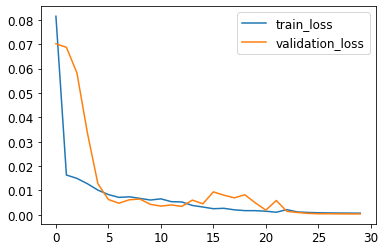

In [71]:
# plot reproduced
plt.plot(h.history['loss'])
plt.plot(h.history['val_loss'])
plt.legend(['train_loss', 'validation_loss'], loc='upper right')

In [22]:
# Get the predicted values
preds = model_.predict(x_test_sc)

# test predictions
preds_unscaled = umt.scaler.inverse_transform(preds)
y_unscaled = umt.scaler.inverse_transform(y_test_sc)

# Get the root mean squarred error (RMSE) and the meadian error (ME)
mse_ = (np.mean(np.square(preds - y_test_sc)))
mse_

0.0009268524865239317

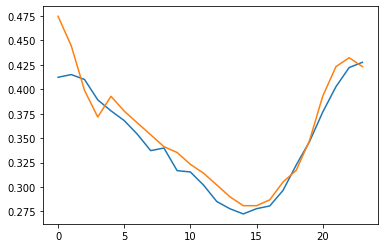

In [23]:
# plot reproduced

plt.plot(preds[1])
plt.plot(y_test_sc[1])